# Figure 3. Human Cortical Timescale: ECoG vs. Structural & Transcriptomic Measures
In this notebook, we look at neuronal timescales in human cortex (measured via iEEG and ECoG) across the brain, and how it relates to known structural gradients (T1w/T2w myelination and gene expression) in the brain.

---

Having shown that we can meaningfully estimate neuronal timescale from field potentials measured with intracranial EEG, we turn to the central question of the study: is there a hierarchy of intrinsic timescales across the entire human cortex, and does its spatial variation correspond to known structural gradients in the human brain?

A number of previous studies have demonstrated, using intracranial electrophysiological data, the existence of a functional hierarchy in limited regions of the human cortex, for example, in visual and auditory areas during sensory processing (e.g., [Honey et al., 2012][honey2012]). Additionally, the slower fMRI BOLD signal follows a spatial gradient supporting the sensory-to-association hierarchical interpretation as well. Structurally, there is evidence that both grey matter myelination and variations in gene expression also follow such a gradient, predominantly in the rostrocaudal direction, and are associated with each other ([Burt et al., 2018][burt2018]). __All this converging evidence strongly suggests the existence of an intrinsic hierarchy across the entire human cortex for fast electrical activity that relates to the various structural hierarchies, but have not been directly shown in humans due to a lack of broad-coverage intracranial single-unit or field potential recordings.__ We take advantage of a large database of human intracranial recordings during rest to show exactly that. Furthermore, we perform gene ontology enrichment analysis (GOEA) using [GOATOOLS][goattools], after choosing genes that are significantly correlated with cortical timescale using partial least squares (PLS) regression (e.g., as in [Whitaker et al., 2016][whitaker2016]), in order to identify gene clusters belonging to functional groupings.

---
Below, we produce an average human cortical neuronal timescale map from ECoG recordings, and compare with T1w/T2w map (from the Human Connectome Project, surrogate for grey matter myelination/anatomical hierarchy, [Glasser & van Essen, 2011][glasser2011]), as well as average postmortem human gene expression map from the Allen Brain Atlas (interpolation from [Gryglewski et al., 2018][gryglewski2018]). All maps are projected onto the HCP-MMP surface parcellation ([Glasser et al., 2016][glasser2016]), but only the left side, for 180 parcels in total.

ECoG data is taken from the [MNI Open iEEG Atlas (e.g., Frauscher et al., 2018)](https://mni-open-ieegatlas.research.mcgill.ca/). It consists of 1772 channels from 106 patients (13-62 years old) with varying coverages. The channels are a mixture of surface strip/grid electrodes and stereoEEG electrodes. ECoG electrode coordinates are originally provided in MNI coordinates, and we project them onto HCP-MMP with a Gaussian-weighted spatial average (done in ./1_analysis_collectDF).

T1w/T2w and gene expression maps are provided by Rudy van den Brink (Tobias Donner lab), where volumetric maps of gene expression from [Gryglewski et al. 2018][gryglewski2018] are projected onto HCP-MMP surface (repo for code [here][rudyrepo]).

All correlations between spatial maps are Spearman rank correlations, and spatial correlation p-values are computed from resampled null distributions using surrogate spatial maps accounting for spatial autocorrelation (Moran Spectral Randomization in the main analysis, but see ./supp_spatialautocorr for details exploring other methods).

---
# TL;DR:

In the same spatial reference frame (HCP-MMP), average neuronal timescales--derived from intracranial data across 106 patients gathered from several hospitals across several years--significantly correlate with average gene expression and GM myelination gradients (from completely different cohorts of people), suggesting a conserved property of the human brain. Furthermore, genes identified as highly associated with cortical timescale are enriched for transmembrane transporter and ion channels (e.g., voltage sensitive sodium and potassium channel genes), as well as synaptic receptors (NMDA and GABA receptor genes). 

[honey2012]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3517908/
[miller2001]: https://www.annualreviews.org/doi/abs/10.1146/annurev.neuro.24.1.167
[burt2018]: https://www.ncbi.nlm.nih.gov/pubmed/30082915
[goattools]: https://www.nature.com/articles/s41598-018-28948-z
[whitaker2016]: https://www.pnas.org/content/113/32/9105
[glasser2011]:https://www.jneurosci.org/content/31/32/11597.long
[gryglewski2018]:https://www.ncbi.nlm.nih.gov/pubmed/29723639
[glasser2016]: https://www.ncbi.nlm.nih.gov/pubmed/27437579
[rudyrepo]:https://github.com/rudyvdbrink/Surface_projection


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from seaborn import despine
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, ttest_1samp, binom_test, zscore, linregress
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from brainspace.null_models import MoranRandomization

# need to grab HCPMMP the first time you run this notebook
import mne
subjects_dir = mne.datasets.sample.data_path() + '/subjects'
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, verbose=True)

import sys
sys.path.append('../')
import echo_utils

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('image', cmap='inferno')

C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig_path = '../figures/mni/%s.pdf'
save_plot=True

********************************************************************************
         to build the TVTK classes (8.2). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



---
# Loading various datasets
### Load parcellation projected ECoG data & structural/transcriptomic data

In [2]:
d_query = 4
df_W_max = pd.read_csv('../data/df_human_W_max_%i.csv'%d_query, index_col=0)
df_tau_weighted = pd.read_csv('../data/df_human_tau_weighted_%i.csv'%d_query, index_col=0)
df_struct = pd.read_csv('../data/df_structural_avg.csv', index_col=0)

# take out genes into separate df because there's a lot of operating on them
df_genes = df_struct[df_struct.columns[1:]]
df_ecog = pd.read_csv('../data/df_human.csv', index_col=0)

# threshold for parcel coverage weight, anything below this for
# gaussian interpolation weight is considered too far and non-coverage
w_thres = 0.5

# get patient info for coverage information
df_patient = df_ecog.groupby('patient').mean()[['gender', 'age']].astype(int)
df_patient.index = df_patient.index.astype(int)
df_patient.insert(len(df_patient.columns), 'coverage', np.sum(df_W_max>=w_thres,1))
df_patient.insert(len(df_patient.columns), 'pct_coverage', np.sum(df_W_max>=w_thres,1)/len(df_W_max.columns))

# compute thresholded and weighted average for average timescale map
df_tau_threshed = df_tau_weighted[df_W_max>=w_thres]
tau_parcel = echo_utils.compute_weighted_average(df_tau_weighted, df_W_max, w_thres, method='weighted')*1000 # convert to ms
df_tau = pd.DataFrame(np.vstack((tau_parcel, np.log10(tau_parcel))).T, columns=['tau', 'logtau'], index=tau_parcel.index)

# save out timescale map
df_tau.to_csv('../data/df_tau_avg.csv')

### Creating spatial autocorrelation preserving null maps with MSR

In [3]:
# parcel geodesic distance
df_parcel_geo = pd.read_csv('../data/LeftParcelGeodesicDistmat.txt', header=None, delimiter=' ')

# get inverse geodesic distance map
w_igd = 1/(df_parcel_geo.values + np.eye(len(df_parcel_geo)))

# make 1000 nulls and run against t1t2 map
n_rand = 1000
ts_msr = MoranRandomization(n_rep=n_rand, procedure='singleton', tol=1e-6, random_state=42)
ts_msr.fit(w_igd)
msr_nulls = ts_msr.randomize(df_tau['logtau'].values)

### Preload geneontology for enrichment analysis

In [4]:
### get human gene GO associations for enrichment analysis
# this will download gene2go annotation and go-basic.obo ontology to the current folder
goea_obj, symbol2id_dict = echo_utils.prep_goea()

  EXISTS: go-basic.obo
  EXISTS: gene2go
go-basic.obo: fmt(1.2) rel(2020-02-21) 47,245 GO Terms
HMS:0:00:03.826376 323,107 annotations, 19,649 genes, 18,246 GOs, 1 taxids READ: gene2go 
CC 18,648 annotated human genes
MF 17,384 annotated human genes
BP 17,541 annotated human genes

Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a


20 GO IDs NOT FOUND IN ASSOCIATION: GO:1901350 GO:0061396 GO:0072365 GO:0072368 GO:0052106 GO:0072369 GO:0060154 GO:0019089 GO:0052066 GO:1900387 GO:0072363 GO:0072366 GO:1902583 GO:1990967 GO:0072362 GO:0098504 GO:0035947 GO:0052213 GO:0035948 GO:0052047


 83% 14,978 of 18,114 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts up: is_a
 87% 15,830 of 18,114 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
Propagating term counts 

1 GO IDs NOT FOUND IN ASSOCIATION: GO:0005924
3 GO IDs NOT FOUND IN ASSOCIATION: GO:0001135 GO:0001004 GO:0001134


up: is_a
 83% 15,021 of 18,114 population items found in association


---
---
# Patient coverage in HCP Multi-Modal Parcellation (HCP-MMP)
First we look at the electrode coverage of the entire dataset. Since spatial smoothing of the ECoG timescale is done with a Gaussian (of a defined width) and across the whole brain, all parcels in a single subject will have an interpolated value even if that person only has electrode coverage in one or two parcels.

We don't want to use the interpolated value in PFC, for example, if it was smoothed over from the visual cortex. So we apply a threshold to include only parcels where the maximum Gaussian weight (confidence) is above a threshold (0.5 here), which means a parcel is only included for a subject if there was an electrode within some distance (4mm for the Gaussian used for smoothing if threshold is 0.5). In hindsight, another way to do this is to truncate the Gaussian at 0.5 during the interpolation stage, saving the headache from doing it here, though that would require recomputing the smoothing for different threshold parameters every time.

colormap sequential: [1.38e-01, 5.69e-01, 1.00e+00] (opaque)
colormap sequential: [0.00e+00, 1.40e+01, 2.80e+01] (opaque)


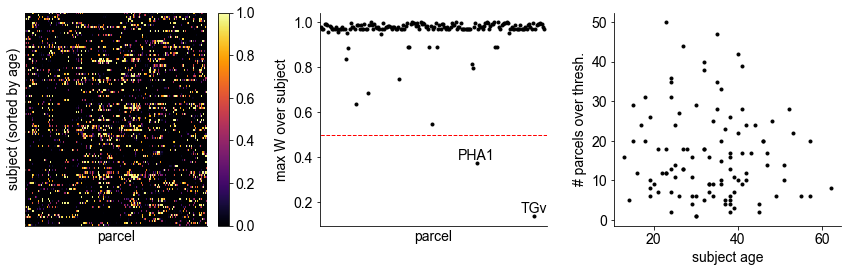

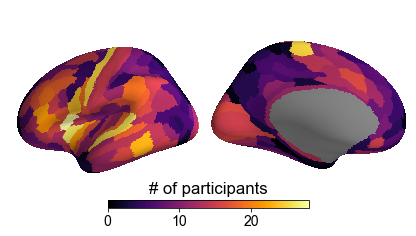

In [5]:
plot_subj_coverage = False
subj_fig_path = '../figures/mni/subj_mmp_coverage/'

# plot aggregate max
echo_utils.plot_MMP(np.max(df_W_max.values, axis=0), subj_fig_path+'aggregate_max.pdf', bp=0)
plt.close()

# plot all subject coverages
# do this once because it takes a long time
if plot_subj_coverage:
    # plot individual subject map
    for s_i, s in df_W_max.iterrows():
        echo_utils.plot_MMP(s.values, subj_fig_path+'subj_%i.pdf'%int(s_i), bp=0, minmax=[0,1], title='age: %i'%df_patient.loc[s_i].age)
        plt.close()
        

# --------
# visualization of thresholded coverage 
plt.figure(figsize=(12,4))

# heat map of weight matrix max (subj x parcel)
plt.subplot(1,3,1)
plt.imshow(df_W_max.values[np.argsort(df_patient['age']).values.astype(int),:], aspect='auto')
plt.xlabel('parcel');plt.ylabel('subject (sorted by age)')
plt.xticks([]);plt.yticks([]); plt.colorbar()

# global maximum weight at each parcel, pooled over subjects
plt.subplot(1,3,2)
region_wmax = np.max(df_W_max.values,axis=0)
plt.plot(region_wmax, 'k.')
plt.plot(plt.xlim(),[w_thres, w_thres], 'r--', lw=1)
plt.xlim([-1,len(region_wmax)+1])
plt.xlabel('parcel');plt.ylabel('max W over subject')
plt.xticks([]); despine()
under_w_thresh = np.where(region_wmax<w_thres)[0]
for w in under_w_thresh:
    plt.text(w, region_wmax[w], df_W_max.columns[w], verticalalignment='bottom', horizontalalignment='center')


# of confident parcels per subject, sorted by age
plt.subplot(1,3,3)
plt.plot(df_patient['age'], df_patient['coverage'],'.k')
plt.xlabel('subject age');plt.ylabel('# parcels over thresh.')
despine()
    
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'mmp_coverage_all')

# number of patients that had coverage at each parcel
parcel_cvg = (df_W_max>=w_thres).sum(axis=0)
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(parcel_cvg, save_file=fig_path%'mmp_coverage_subjs', bp=0, title='# of participants');

We see that coverage is quite sparse and idiosyncratic across patients (data matrix in first column, also see individual subject plots in ../figures/mni/subj_mmp_coverage/). The full data matrix is around 10% populated, but pooling across subjects, most parcels have at least one patient with an electrode very close to it (weight value of >0.9). PHA1 and TGv are the only parcels that do not meet the threshold in even a single patient. The best coverage are in sensorimotor, temporal, and frontal regions (which makes sense for epilepsy localization). Temporal-occipital-parietal junction areas are also not bad, and visual regions are surprisingly well covered.

Also, a few subjects between 25-40 years old have coverages that are much more than normal (>30 parcels), but overall there isn't a huge difference in coverage location (first column of top figure) nor total coverage (third column) across age, which is important to check for the age analysis later on.

colormap sequential: [2.50e+01, 3.25e+01, 4.00e+01] (opaque)


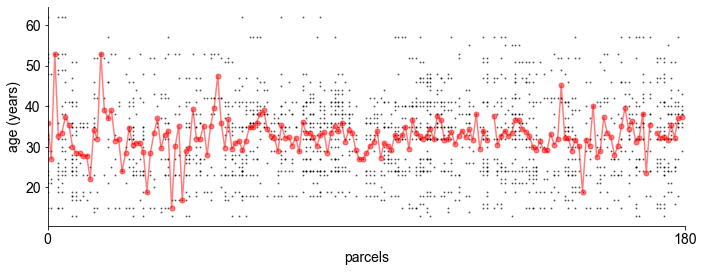

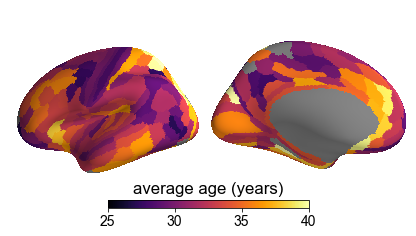

In [6]:
df_parcel_age = pd.DataFrame(np.repeat(df_patient['age'].values[:,None], len(df_W_max.columns), axis=1)).reindex_like(df_W_max)
df_parcel_age.iloc[:,:] = np.repeat(df_patient['age'].values[:,None], len(df_W_max.columns), axis=1)
df_parcel_age[df_W_max<w_thres]=np.nan

plt.figure(figsize=(10,4))
plt.plot(df_parcel_age.T.values, '.k', alpha=0.5, ms=2);
plt.plot(np.nanmean(df_parcel_age,axis=0), 'or-', alpha=0.5, ms=5);
plt.ylabel('age (years)'); plt.xlabel('parcels'); 
plt.xticks([0, 180]);plt.xlim([0, 180])
despine(); plt.tight_layout()
if save_plot: plt.savefig(fig_path%'mmp_coverage_age')

plt.figure(figsize=(6,6))
echo_utils.plot_MMP(np.nanmean(df_parcel_age,axis=0), save_file=fig_path%'mmp_coverage_mean_age', bp=0, minmax=(25,40), title='average age (years)');

Looking across parcels, we see that there isn't a huge or systematic variation in the age of particpants. Mean age across parcels pretty consistently lie around 30-40 years old, meaning age should not influence average timescale estimate greatly.

---
# Hierarchy of neuronal timescale across human cortex
### Here's what we're all here for: neuronal timescale gradient across the cortex.

colormap sequential: [1.00e+01, 3.00e+01, 5.00e+01] (opaque)
colormap sequential: [1.00e+00, 1.35e+00, 1.70e+00] (opaque)


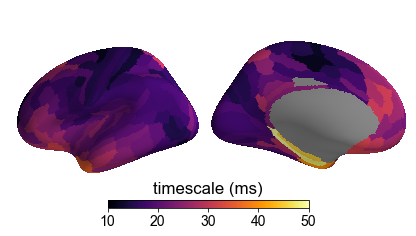

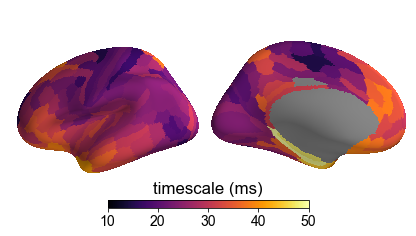

In [7]:
# plot grand average timescale on MMP
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau['tau'], save_file=fig_path%'map_tau', minmax=[10,50], bp=0, title='timescale (ms)')

# plot log-spacing for more obvious contrast
#### NOTE THAT THE TICKS ARE NOT CORRECTLY SPACED IN THE SECOND PLOT ###
# ONLY 10 and 50 ARE IN THE RIGHT PLACE ####
## THIS IS CORRECTED POST-PRODUCTION ##

plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau['logtau'], bp=0, minmax=[1,np.log10(50)], title='timescale (ms)')
plt.clim([10, 50])
plt.savefig(fig_path%'map_tau_log', bbox_inches='tight')

### Human neuronal timescale has a rostrocaudal spatial gradient
The above visualizes the gradient of human cortical timescales projected onto HCP-MMP. Qualitatively, we see that timescale has a dominant back-to-front gradient. More specifically, timescales are shorter (faster) in sensory regions (sensorimotor, visual), while association regions (especially posterior parietal and ventral/medial frontal) and medial temporal/hippocampal regions have longer timescales. (Note that the second graph has log-spaced values, but the colorbar is incorrect here. This is fixed in the paper figure.)

This is consistent with reports in previous literature, where population timescales increase from sensory to association regions, but for the first time shown here for fast-timescale (synaptic and transmembrane current fluctuation) dynamics across the whole human brain.

---
# Timescale vs. T1w/T2w ratio (anatomic hierarchy)
In the next set of analyses, we look at the parcel-wise spatial correlation between grand average timescale, and anatomical (T1w/T2w MR image ratio) & gene expression hierarchy.

colormap sequential: [-2.50e+00, 0.00e+00, 2.50e+00] (opaque)


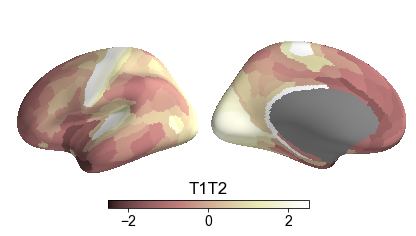

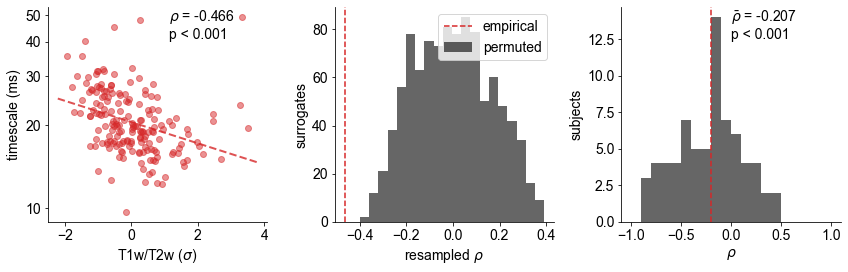

In [8]:
struct_feat = 'T1T2'
x = zscore(df_struct[struct_feat].values)
y = df_tau['logtau']

# plot feature on MMP brain
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(zscore(x), save_file=fig_path%'map_T1T2', minmax=[-2.5,2.5], bp=0, title=struct_feat, cmap='pink')

# --- group average correlation ----
rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,y.values,msr_nulls)
m,b,_,_,_ = linregress(x,y.values)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(x, y, 'o', color=C_ORD[3], alpha=0.5);
XL= np.array(plt.xlim())
plt.plot(XL,XL*m+b, '--', lw=2, color=C_ORD[3], alpha=0.8)
plt.xlabel(r'T1w/T2w ($\sigma$)'); 
plt.ylabel('timescale (ms)');
plt.yticks(np.log10(np.arange(10,60,10)), (np.arange(10, 60, 10)).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)
s = echo_utils.sig_str(rho, pv_perm, form='text')
plt.annotate(s, xy=(0.55, 0.85), xycoords='axes fraction')

plt.subplot(1,3,2)
plt.hist(rho_null, 20, color='k', alpha=0.6, label='permuted');
plt.axvline(rho, color=C_ORD[3], ls='--', label='empirical')
plt.legend()
plt.xlabel(r'resampled $\rho$'); plt.ylabel('surrogates')

# --- per-subject correlation ---
df_subj_corr = pd.DataFrame(index=df_tau_weighted.index, columns=['n_parcels', 'rho', 'pv'])
for i_s, subj in df_tau_threshed.iterrows():
    df_subj_corr['n_parcels'].loc[i_s] = (~np.isnan(subj)).sum()
    if df_subj_corr['n_parcels'].loc[i_s]>=3:
        rho, pv = spearmanr(x, subj, nan_policy='omit')
    else:
        rho, pv = np.nan, np.nan
    df_subj_corr['rho'].loc[i_s],df_subj_corr['pv'].loc[i_s] = rho,pv

# minimum # of parcels required for a subject to be counted in histogram
min_parcels = 10
    
# only count correlations from subjects that had min # of parcels
corr_valid = df_subj_corr[df_subj_corr['n_parcels']>=min_parcels]['rho'].values.astype(float)
tt_pv = ttest_1samp(corr_valid, 0)[1]

plt.subplot(1,3,3)
plt.hist(corr_valid, bins=np.arange(-1,1.1,0.1), color='k', alpha=0.6)
plt.axvline(np.nanmean(corr_valid), color=C_ORD[3], ls='--')
plt.xlabel(r'$\rho$');plt.ylabel('subjects');
s = echo_utils.sig_str(np.nanmean(corr_valid), tt_pv, form='text', corr_letter=r'$\bar{\rho}$')
plt.annotate(s, xy=(0.50, 0.85), xycoords='axes fraction')

despine(); plt.tight_layout()
plt.savefig(fig_path%'tau_T1T2', bbox_inches='tight')

### Neuronal timescale is positively correlated with anatomic hierarchy (negatively with T1w/T2w)
T1w/T2w ratio is a measure of gray matter myelination, and has been shown to be higher in sensory regions (converging long-range connections) than association regions (local recurrent connections).

Overall, ECoG timescales are significantly and negatively correlated with T1w/T2w, i.e., positively correlated with anatomical hierarchy (left). This is true on average and at the individual subject level (only subjects with at least min_parcel number of parcels are included). This means areas with higher T1w/T2w values (higher myelination) have shorter timescales, again suggesting shorter timescale dynamics in primary sensory regions. There are exceptions, however, such as the lone dot in the top right corner, and the neighborhood of datapoints to the middle right (high T1w/T2w, intermediate timescale). Middle plot shows resampled distribution of correlation coefficients using surrogate timescale maps and T1T2, accounting for spatial autocorrelation, as an example of the permutation analysis.

We can also look at this correlation within each subject (right). Since coverage varies between patients, we set a threshold where a subject is included only if they have at least min_parcel number of parcels (10 here). Again, correlations are significantly negative (2-sided 1-sample t-test) but with exceptions.

### In summary, fast synaptic fluctuation timescales measured via human intracranial ECoG is significantly correlated with, and may index, anatomical hierarchy, which itself is an index of feedforward vs. recurrent dominant architecture.

---
# Timescale vs. transcriptomic (gene expression) gradient
Next, we look at how the gradient of neuronal timescale matches gene expression gradients. Previous work has already demonstrated a relationship between T1w/T2w ratio and gene expression across the human cortex, so we should expect a relationship between timescale and overall gene expression gradient as well. To do this, we compute gene expression gradients using PCA and examine its relationship with neuronal timescale.

colormap sequential: [-2.50e+00, 0.00e+00, 2.50e+00] (opaque)


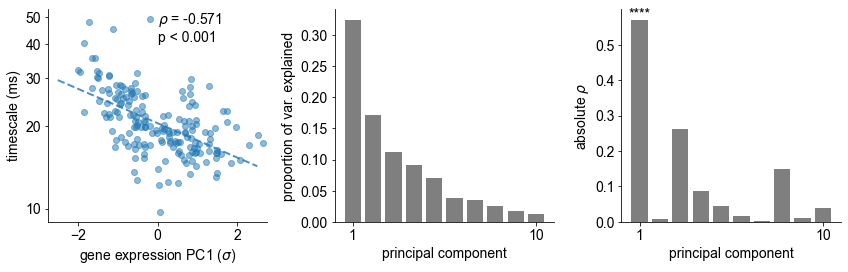

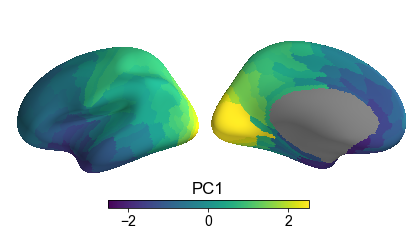

In [9]:
# perform PCA on all genes
n_pcs = 10
gene_pca = PCA(n_pcs)
gene_grad = gene_pca.fit_transform(df_genes.values)
df_pc_weights = pd.DataFrame(gene_pca.components_.T, index=df_genes.columns, columns=['pc%i'%i for i in range(1, n_pcs+1)])

# compute correlation
x = zscore(gene_grad[:,0])
y = df_tau['logtau']
rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,y.values,msr_nulls)
m,b,_,_,_ = linregress(x,y.values)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(x, y, 'o', color=C_ORD[0], alpha=0.5)
plt.xlim([-2.75, 2.75]); 
XL= np.array([-2.5,2.5])
plt.xticks([-2, 0, 2])
plt.plot(XL,XL*m+b, '--', lw=2, color=C_ORD[0], alpha=0.8)
plt.xlabel(r'gene expression PC1 ($\sigma$)'); plt.ylabel('timescale (ms)');
plt.yticks(np.log10(np.arange(10,60,10)), (np.arange(10, 60, 10)).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)
#plt.annotate(echo_utils.sig_str(rho, pv_perm, form='text'), xy=(0.7,0.05), xycoords='axes fraction');
s = echo_utils.sig_str(rho, pv_perm, form='text')
plt.annotate(s, xy=(0.50, 0.85), xycoords='axes fraction')

plt.subplot(1,3,2)
plt.bar(range(1,n_pcs+1), gene_pca.explained_variance_ratio_, fc='k', alpha=0.5)
plt.xticks([1, 10], ['1', '10']);
plt.xlabel('principal component'); plt.ylabel('proportion of var. explained'); despine();

plt.subplot(1,3,3)
all_pc_rhos = np.array([echo_utils.compute_perm_corr(x, y, msr_nulls)[:3] for x in gene_grad.T])

plt.bar(range(1,n_pcs+1), np.abs(all_pc_rhos[:,0]), fc='k', alpha=0.5)
for i in range(1,11):    
    plt.annotate('*'*sum(all_pc_rhos[i-1,2]<[0.05, 0.01, 0.005, 0.001]), (i, abs(all_pc_rhos[i-1,0])+0.005), horizontalalignment='center')
plt.xticks([1, 10], ['1', '10']);
plt.xlabel('principal component'); plt.ylabel(r'absolute $\rho$'); despine();

plt.tight_layout();
plt.savefig(fig_path%'tau_genePC1', bbox_inches='tight')

# plot PC1 on brain
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(x, save_file=fig_path%'map_gene_PC1', bp=0, minmax=[-2.5,2.5], title='PC1', cmap='viridis')
# plot all gene PCs on MMP brain
# for i_pc in range(1,5):
#     plt.figure(figsize=(6,6))
#     echo_utils.plot_MMP(zscore(gene_grad[:,i_pc]), save_file=fig_path%('map_gene_PC'+str(i_pc+1)), bp=0, minmax=[-2.5,2.5], title='PC%i'%(i_pc+1), cmap='viridis')

### Neuronal timescale is associated with dominant gene expression gradient
We look at total gene expression gradient across the cortex altogether via PCA, and compare that with neuronal timescale. The full list of genes can be found in the data table in ../df_structural.csv, which contains all genes from the Allen Brain Human Transcriptomics dataset. 

As shown above, timescale is significantly correlated with the dominant gene expression gradient (left, 1st principal component), even more so than with anatomical hierarchy, but not the other remaining PCs (right). Note that the direction of correlation is arbitrary here as PCA on the gene expression matrix is agnostic to direction.

In [10]:
# save out these main features in one table
pd.DataFrame(
    np.hstack((df_tau.values, df_struct['T1T2'].values[:,None], gene_grad[:,0][:,None])),
    index = df_struct.index,
    columns=['tau', 'logtau', 'T1T2', 'gPC1']
).to_csv('../data/df_human_features.csv')

---
### Correlations with specific genes with known roles in altering neuronal & synaptic timescales
Extracellular voltage fluctuations measured via LFP and ECoG are predominantly caused by transmembrane currents, whose timescales depend both on the neuronal (membrane & dendritic) integration and synaptic time constants. Therefore, expression of proteins responsible for ionic transport, synaptic receptors, and other transmembrane current-related genes should have a much more direct relationship with transmembrane current timescale as measured through ECoG, as the amount of ion channels and receptors in a local population of neurons directly alter the timecourse of the synaptic current (e.g., NMDA), and therefore the membrane current fluctuations. We test this by computing individual timescale-gene correlations below.

In [11]:
# run correlation with all genes, with unadjusted p-values from spearman
# only compute the permuted p-values for the ones plotted, otherwise it takes way too long for all 18k genes
df_tau_gene_corrall = pd.DataFrame([spearmanr(g.values, y.values) for g_i, g in df_genes.iteritems()], columns=['rho','pv'], index=df_genes.columns)

0.4680473677171106
-0.6006461104766608
-0.6099365206745063
0.5082667160509069
-0.6150436741874749
0.4483265944422153


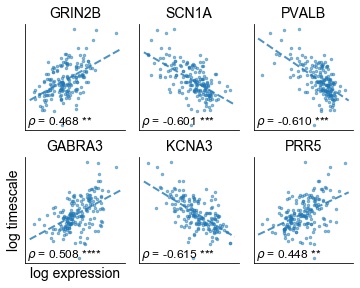

In [12]:
xlb = ['GRIN2B', 'SCN1A', 'PVALB', 'GABRA3', 'KCNA3', 'PRR5']

plt.figure(figsize=(5,4))
y = df_tau['logtau']
xs = [df_struct[g] for g in xlb]

for i_x, x in enumerate(xs):
    rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,y.values,msr_nulls)
    m,b,_,_,_ = linregress(x,y.values)

    plt.subplot(2,3,i_x+1)
    plt.plot(x, y, '.', color=C_ORD[0], alpha=0.5, ms=5);
    XL= np.array(plt.xlim())
    plt.plot(XL,XL*m+b, '--', lw=2, color=C_ORD[0], alpha=0.8)    
    plt.xticks([]); plt.yticks([])
    #plt.tick_params('y', which='minor', left=False, labelleft=False)
    rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,df_tau['logtau'].values,msr_nulls)
    plt.annotate(echo_utils.sig_str(rho, pv_perm, form='*'), xy=(0.02,0.05), xycoords='axes fraction', fontsize=12);
    print(rho)
    plt.title(xlb[i_x], fontsize=14)
    
plt.subplot(2,3,4)
plt.xlabel('log expression');plt.ylabel('log timescale');
despine(); plt.tight_layout(pad=0.5)
plt.savefig(fig_path%'tau_gene_corr_single', bbox_inches='tight')

### Timescale correlates with single genes
As expected, neuronal timescale correlates with genes encoding for specific subunits of NMDA and GABA-A receptors (GRIN2B & GABRA3), voltage gated sodium and potassium channels (SCN1A & KCNA3), as well as inhibitory cell type markers (parvalbumin, PVALB) and genes identified to be associated with single neuron membrane time constants (PRR5, more on this below).

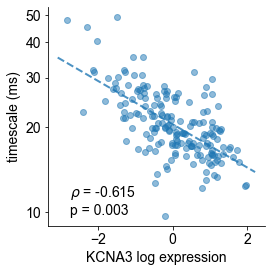

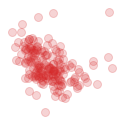

In [13]:
# Don't mind these plots, they're just for making the paper figures...
###### code snippet just to make a bigger pretty scatterplot 
plt.figure(figsize=(4,4))

query_gene = 'KCNA3'
x = df_struct[query_gene]
y = df_tau['logtau']
rho, pv, pv_perm, rho_null = echo_utils.compute_perm_corr(x,df_tau['logtau'].values,msr_nulls)

plt.plot(x, y, 'o', alpha=0.5);
m,b,_,_,_ = linregress(x,y.values)
XL= np.array(plt.xlim())
plt.plot(XL,XL*m+b, '--', lw=2, color=C_ORD[0], alpha=0.8) 
plt.xlabel(query_gene+' log expression'); plt.ylabel('timescale (ms)'); 
plt.yticks(np.log10(np.arange(10,60,10)), (np.arange(10, 60, 10)).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)
plt.annotate(echo_utils.sig_str(rho, pv_perm, form='text'), xy=(0.1,0.05), xycoords='axes fraction');
plt.tight_layout(); despine()
#plt.savefig(fig_path%('tau_gene_corr_'+query_gene), bbox_inches='tight')

###### tiny plot for schematic figure
plt.figure(figsize=(2,2))

x = df_struct['T1T2']
y = df_tau['logtau']
plt.plot(x, y, 'o', color=C_ORD[3], alpha=0.2, ms=8)
plt.xticks([]);plt.yticks([]); 
plt.tight_layout(); despine(left=True, bottom=True)
plt.savefig(fig_path%'tau_T1T2_tiny', bbox_inches='tight')

### Query some gene families related to timescale

In [14]:
geneset_nmda = ['GRIN1', 'GRINA', 'GRIN2A','GRIN2B','GRIN2C','GRIN2D','GRIN3A', 'GRIN3B'] # nmda receptor
geneset_gabra = ['GABRA1','GABRA2','GABRA3','GABRA4','GABRA5','GABRA6'] # GABA-A alpha subchannels
geneset_sodium = ['SCN1A',  'SCN2A',  'SCN3A', 'SCN4A',  'SCN5A', 'SCN7A', 'SCN8A', 'SCN9A', 'SCN10A']#,'SCN1B','SCN2B','SCN3B',SCN4B'] # sodium ion channels
geneset_potassium = ['KCNA1','KCNA2','KCNA3','KCNA4','KCNA5','KCNA6'] # GABA-A alpha subchannels
geneset_inh = ['CORT', 'CALB1', 'CALB2', 'SST', 'PVALB', 'CCK', 'NPY', 'PNOC', 'VIP'] # inhibitory markers
geneset_sctau = ['CELF6', 'PRR5', 'FAM81A', 'LRRC4C','OXTR', 'CTXN1', 'ENC1', 'AKAIN1'] # single-cell membrane time constant
gene_families = [geneset_nmda, geneset_gabra, geneset_sodium, geneset_potassium, geneset_inh, geneset_sctau]

df_tau_gene_corrfam = pd.DataFrame([], index=sum(gene_families, []), columns=['rho', 'pv', 'pv_adj'])
for i_g, g in df_tau_gene_corrfam.iterrows():
    df_tau_gene_corrfam.loc[i_g] = echo_utils.compute_perm_corr(df_genes[i_g].values, df_tau['logtau'].values, msr_nulls)[0:3]

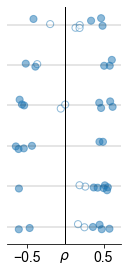

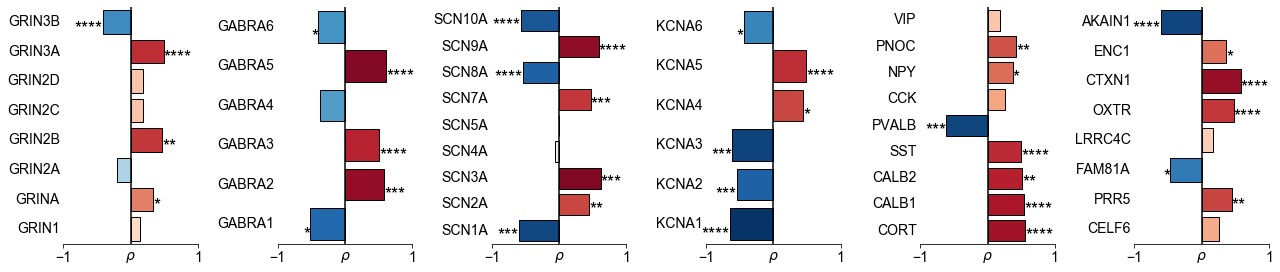

In [15]:
# plot all correlations
plt.figure(figsize=(2,4))
plt.axvline(0, color='k', lw=1)
for i_g, gs in enumerate(gene_families):
    set_x = df_tau_gene_corrfam.loc[gs]['rho']
    set_y = np.random.randn(len(gs))/15+(5-i_g)

    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_tau_gene_corrfam.loc[gs]['pv_adj']]
    plt.axhline(5-i_g, lw=0.2, color='k')
    plt.scatter(set_x, set_y, alpha=0.5, s=50, ec = C_ORD[0], c = set_color)
    

plt.xlabel(r'$\rho$', labelpad=-15)
plt.yticks([]); plt.xticks([-0.5, 0.5]);

despine(left=True); plt.tight_layout()
plt.savefig(fig_path%'tau_gene_corr_family', bbox_inches='tight')

# another view, plot families of correlations as hbar
color = plt.cm.RdBu_r(np.linspace(0,1,200))
plt.figure(figsize=(18,4))
for i_g, g_subset in enumerate(gene_families):
    plt.subplot(1,len(gene_families),i_g+1)
    geneset_plot = df_tau_gene_corrall.loc[g_subset]
    for i_p in range(len(geneset_plot)):
        rho, pv_perm = df_tau_gene_corrfam.loc[geneset_plot.iloc[i_p].name][['rho', 'pv_adj']]
        plt.barh(i_p, rho, ec='k', fc=color[int((1+rho*1.5)*100)])
        s = np.sum(pv_perm<=np.array([0.05, 0.01, 0.005, 0.001]))*'*'
        plt.text(rho, i_p-0.4, s, fontsize=18, horizontalalignment='left' if rho>0 else 'right')

    plt.plot([0,0], plt.ylim(), 'k')
    plt.ylim([-0.5,len(geneset_plot)-0.5])
    plt.yticks(range(len(geneset_plot)), geneset_plot.index.values, rotation=0, ha='right', va='center', rotation_mode='anchor', fontsize=14)
    plt.tick_params(axis='y', which=u'both',length=0)
    plt.xlim([-1,1]); plt.xlabel(r'$\rho$', labelpad=-15); plt.xticks([-1,1])

despine(left=True);
plt.tight_layout()
plt.savefig(fig_path%'tau_gene_corr_fam_bars',  bbox_inches='tight')

### Timescale is significantly correlated with families of genes
To demonstrate that the previous single-gene correlations were not cherry-picked for significance, the above plots shows correlations for all genes within those same families, from left to right: NMDA receptor subunits (GRINx), GABA-A receptor alpha subunits (GABRAx), voltage gated sodium and pottasium channel subunits (SCNxA & KCNAx), all inhibitory cell-type markers, and single neuron "time-constant" genes (explained further below).

While the expression of many of these genes are strongly correlated with timescale (solid circles denote significance of p<0.05 from permutation test), the direction of correlation depends on the particular gene. This means that the transcriptomic basis of neuronal timescale is not as simple as excitation vs. inhibition (e.g., NMDA vs. GABA), but specific combinations of receptor subunits that are differentially expressed across the cortex with modulatory effects on channel or synaptic activation timescale.

---
A quick note on synaptic receptor and ion transporter complex __subunits__: synaptic receptors, for example, are composed of several subunits, and each subunit can have several isoforms that can be swapped in and out, modulating different aspects of synapse function. Differential expression of a particular isoform of a subunit can denote cell-type differences. For example, per [Wikipedia](https://en.wikipedia.org/wiki/GRIN2B): 

> "NMDA receptor channels are heterotetramers composed of two molecules of the key receptor subunit NMDAR1 (GRIN1) and two drawn from one or more of the four NMDAR2 subunits: NMDAR2A (GRIN2A), NMDAR2B (GRIN2B), NMDAR2C (GRIN2C), and NMDAR2D (GRIN2D)." 
---

Following the example of NMDA, in particular: an NMDA synapse is often composed of 4 subunit proteins (heteroTETRAmer), 2 GluN1 and 2 of GluN2x, where x is A,B,C, or D (corresponding to genes GRIN2A-D). Previous in-vitro work has shown that increased GluN2A expression during development decreases NMDA time course ([Flint et al., 1997][flint1997]), while the ratio of subunits GluN2B to GluN2A (GRIN2B & GRIN2A) is positively correlated with NMDA current decay time constant (more GluN2B lengthens NMDA currents, [Monyer et al. 1994][monyer1994]). If this presented at the mesoscale, we would expect neuronal timescale inferred from cortical regions to be positively correlated with GRIN2B expression while negatively associated with GRIN2A expression, and that's exactly what's shown above.

Similar in-vitro findings were reported in human embryonic kidney (HEK) cells transfected with GABAA3 vs. GABAA1 cDNA, where receptor deactivation time constant increases with a3:a1 ratio ([Eyre et al., 2012][eyre2012]). Again, GABRA3 and GABRA1 are positively and negatively associated with cortical neuronal timescale here, respectively, as predicted.

Additionally, voltage-gated sodium and potassium channel subunit genes (e.g., alpha) are also highly associated with timescale (3rd & 4th column). Interestingly, all inhibitory cell-type markers (5th column) are positively correlated with timescale, with the exception of parvalbumin (perhaps because PV+ interneurons are most often found in early sensory areas).

The final list of genes were found in a single-cell transcriptomic study (from single cell Patch-Seq recordings) as to be highly associated with single-cell membrane fluctuation timescale properties (GLIF-model fitted time constant, resistance, and capacitance, [Bomkamp et al., 2019][bomkamp2019], Table 2). Here, we show that bulk expression of these genes are also correlated with mesoscale measures of transmembrane current timescale in the population (shown below, same directions as predicted from single-cells, binomial test). This suggests that the field potential signal is related to intracellular membrane potential fluctuations, which, of course, there is sufficient evidence for from simultaneous intra- and extracellular recordings.

[bomkamp2019]:https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007113
[flint1997]:https://www.ncbi.nlm.nih.gov/pubmed/9065507
[monyer1994]:https://www.ncbi.nlm.nih.gov/pubmed/7512349
[eyre2012]:https://www.jneurosci.org/content/32/17/5853

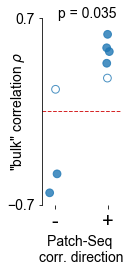

In [16]:
# time constant gene directions
sc_corr_dir = [1,1,-1,-1,1,1,1,-1]
agreement = np.sign(df_tau_gene_corrfam.loc[geneset_sctau]['rho'].values)*sc_corr_dir
p_binom = binom_test((agreement>0).sum(), len(agreement), alternative='greater')
set_x = np.random.randn(len(gs))/10+np.array(sc_corr_dir)
set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_tau_gene_corrfam.loc[geneset_sctau]['pv_adj'].values]

plt.figure(figsize=(2,4))
plt.scatter(set_x, df_tau_gene_corrfam.loc[geneset_sctau]['rho'].values, alpha=0.8, s=60, ec = C_ORD[0], c = set_color)
plt.axhline(0, color=C_ORD[3], ls='--', lw=1)
plt.annotate('p = %.3f'%p_binom, xy=(0.2,1), xycoords='axes fraction');
plt.xlim([-1.5,1.5]); plt.xticks([-1,1], ['-', '+'],fontsize=20); plt.xlabel('Patch-Seq \ncorr. direction')
plt.yticks([-0.7,0.7]); plt.ylabel(r'"bulk" correlation $\rho$', labelpad=-20)

despine(bottom=True); plt.tight_layout()
plt.savefig(fig_path%'tau_gene_corr_patchseq', bbox_inches='tight')

### Mesoscale timescale-gene correlations (ECoG & bulk expression) recapitulate known associations at the single-cell level

In summary, transmembrane current fluctuation timescales measured via ECoG are also strongly correlated with average gene expression of many synaptic receptors, transmembrane ion transport complexes, and cell-type marker proteins, linking dynamics with its potential structural support. It also argues for the importance of these slower currents in accurately modeling the field potential/ECoG signal.

---
# Gene ontology enrichment analysis (GOEA)
From the previous correlation analysis, we can evaluate the association between neuronal timescale and the expression variation of individual genes, specifically a handful of those that are known to be involved in time constant modulation at the synaptic or single cell level. However, there are ~18000 genes in the AHBA database, and it's impossible to systematically examine each gene's relationship with cortical timescale manually, but we would like to identify if some functional clusters of genes are more associated with timescale. For example, are sodium and potassium ion channel subunit genes the only ones that are highly associated, or do all or most other ion channels contribute to shaping cortical timescale as well, such as calcium and chloride channels? Do other types of synaptic receptors, aside from NMDA and GABA-A?

To answer this question in a quantitative and unbiased way, we perform gene ontology enrichment analysis (for a clear primer, see [here][goea_primer]). Briefly, a list of genes that are highly associated with neuronal timescale are identified and compared to annotations that link groups of genes to items in the gene ontology, which contains 21k items annotated as being associated with protein pathways in biological processes (BP), molecular functions (MF), or cellular components (CC). These gene ontology items are hierarchical, e.g., NMDA receptor subunit genes (GRINx) are tagged to "synaptic signaling" at the highest level, but also to "chemical synaptic transmission", "glutamatergic synaptic transmission", etc. GOEA identifies gene ontology items with associated genes that significantly overlap with the submitted list of enriched genes, more so than expected by chance. See Figure 3i in the manuscript for a schematic, see [here][go_annot] for example of gene-ontology annotations.

Here, to identify the list of enriched genes (i.e., those highly associated with neuronal timescale), we use partial least squares regression, a multivariate approach popular in the neuroimaging-transcriptomics literature to simultaneously estimate regression coefficients for all 18k genes. Similar to establishing significance in the correlation analysis, we also fit PLS to each of the 1000 surrogate timescale maps generated using MSR to conserve spatial autocorrelation, and genes whose empirical PLS weight magnitude (absolute value) that is greater than 95% of its surrogate weight distribution (p<0.05, two sided) are considered to be highly associated (one can imagine using the univariate correlation coefficient as the metric of choice as well with thresholding). That list of genes is submitted for GOEA, and a list of GO items is returned. We should expect those GO items to be specifically related to synaptic transmission and ionic transport, as the previous analysis would suggest, if neuronal timescale measured from intracranial recordings represent synaptic and transmembrane current fluctuations. This would further link neuronal dynamics across the cortex to its structural basis, manifested as gene expression.

[goea_primer]:https://link.springer.com/protocol/10.1007%2F978-1-4939-3743-1_13
[go_annot]:http://www.informatics.jax.org/vocab/gene_ontology/GO:0046907

In [17]:
# fit PLS model to empirical maps
pls = PLSRegression(n_components=1)
X = df_genes.values
Y = df_tau['logtau'].values
pls.fit(X, Y)
pls_coefs_emp = pls.coef_.squeeze()

# fit PLS to surrogate maps to get null distribution
pls_coefs_nulls = np.zeros((msr_nulls.shape[0], len(pls_coefs_emp)))
for i_y, Y in enumerate(msr_nulls):
    pls.fit(X, msr_nulls[i_y,:])
    pls_coefs_nulls[i_y,:] = pls.coef_.squeeze()
    
# find permuted p-values
pv_pls_coefs = 1-(abs(pls_coefs_emp)>abs(pls_coefs_nulls)).sum(0)/msr_nulls.shape[0]

# make df of genes and their PLS weights & pvalues
df_pls = pd.DataFrame(np.vstack((pls_coefs_emp, zscore(pls_coefs_emp), pv_pls_coefs)).T, columns=['w', 'w_zscore', 'pv'], index=df_genes.columns)

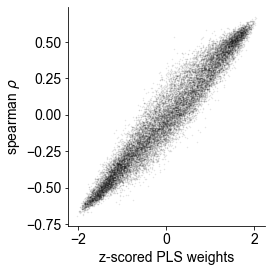

In [18]:
plt.figure(figsize=(4,4))
plt.plot(df_pls['w_zscore'], df_tau_gene_corrall['rho'], '.k', alpha=0.1, ms=1)
plt.xlabel('z-scored PLS weights');plt.ylabel(r'spearman $\rho$');
plt.tight_layout(); despine()

In the above, we see that PLS weight of individual genes is highly correlated with, but not identical, to the spearman correlation coefficient (with timescale). The larger the association, i.e., at the extremes of the cloud, the more similar the two values are (in rank).

### Run GOEA analysis with PLS-significant genes

In [19]:
df_gores = echo_utils.run_goea(df_pls, symbol2id_dict, goea_obj, posneg='all')

# just splitting into 2 lines otherwise it gets unsightly
df_goea, df_goea_sig, goea_results, enriched_genes = df_gores
df_goea_sig


Run BP Gene Ontology Analysis: current study set of 2830 IDs ...
 83%  2,358 of  2,830 study items found in association
100%  2,830 of  2,830 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   9,391 GO terms are associated with  2,358 of  2,830 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 2830 IDs ...
 88%  2,486 of  2,830 study items found in association
100%  2,830 of  2,830 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
   1,203 GO terms are associated with  2,486

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
15226,GO:1990351,e,CC,2,transporter complex,77,312,0.027208,0.026890
15227,GO:1902495,e,CC,3,transmembrane transporter complex,75,304,0.026502,0.026890
15228,GO:0034702,e,CC,4,ion channel complex,70,282,0.024735,0.030218
15229,GO:0034703,e,CC,5,cation channel complex,54,207,0.019081,0.032011
16047,GO:1990904,p,CC,2,ribonucleoprotein complex,65,644,0.022968,0.026890
16048,GO:0005634,p,CC,5,nucleus,654,4720,0.231095,0.032011


---
### Neuronal timescale is specifically associated with genes encoding for transmembrane transporter proteins
When genes highly associated with timescale are submitted for GOEA (positive and negative), we identify GO items above in the cellular components ontology (CC) relating to transmembrane transporter complex, specifically cation channel complexes at the lowest level (e.g., sodium & potassium). The first 4 GO items are actually on one branch at subsequent depths. Interestingly, we also identify a purification (i.e., lack) of genes associated with cell nuclei structures, meaning, there are fewer than expected number of genes in the enrichment list that fall into those GO items than would be expected by chance.

---

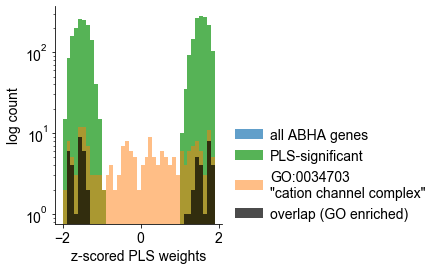

In [20]:
alpha=0.05
goea_results_sig = [r for r in goea_results if r.p_fdr_bh < 0.05]
goea_plot = goea_results_sig[3]
id2symbol_dict = {v:k for k,v in symbol2id_dict.items()}
bins = np.arange(-2,2,0.1)
plt.figure(figsize=(3,4))
plt.bar(0,0, alpha=0.7)
plt.hist(df_pls[df_pls['pv']<alpha]['w_zscore'].values, bins, color=C_ORD[2], alpha=0.8, density=False);
plt.hist(df_pls.loc[[id2symbol_dict[gid] for gid in goea_plot.pop_items]]['w_zscore'].values, bins, color=C_ORD[1], alpha=0.5, density=False);
plt.hist(df_pls.loc[[id2symbol_dict[gid] for gid in goea_plot.study_items]]['w_zscore'].values, bins, color='k', alpha=0.7, density=False);
plt.xlabel('z-scored PLS weights');plt.ylabel('log count')
plt.yticks([]); plt.yscale('log')
despine()
plt.legend(['all ABHA genes', 'PLS-significant', 'GO:0034703\n\"cation channel complex\"', 'overlap (GO enriched)'], bbox_to_anchor= (1, 0.5), ncol=1, frameon=False, handletextpad=0.5)
plt.savefig(fig_path%'GOEA_distr_schematic', bbox_inches='tight')

(The histogram above is a schematic of the GOEA analysis, with a particular example GO item that was identified to be enriched (cation channel complex). Orange bars show distribution of PLS weights for all genes in the GO item, while green bars show PLS weights for all enriched genes. This GO item was found to be enriched because the overlap (black bars) is larger than expected by chance.)

In [21]:
# positive genes only
df_gores = echo_utils.run_goea(df_pls, symbol2id_dict, goea_obj, posneg='pos')
# just splitting into 2 lines otherwise it gets unsightly
df_goea_pos, df_goea_sig_pos, goea_results_pos, enriched_genes_pos = df_gores
df_goea_sig_pos


Run BP Gene Ontology Analysis: current study set of 1452 IDs ...
 81%  1,180 of  1,452 study items found in association
100%  1,452 of  1,452 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   7,390 GO terms are associated with  1,180 of  1,452 study items
  METHOD fdr_bh:
      97 GO terms found significant (< 0.05=alpha) ( 79 enriched +  18 purified): statsmodels fdr_bh
     483 study items associated with significant GO IDs (enriched)
     623 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1452 IDs ...
 88%  1,273 of  1,452 study items found in association
100%  1,452 of  1,452 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
     944 GO terms are associated with  1,273

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
0,GO:0002684,e,BP,4,positive regulation of immune system process,104,793,0.071625,0.000532
1,GO:0045087,e,BP,6,innate immune response,58,368,0.039945,0.000776
2,GO:0002274,e,BP,4,myeloid leukocyte activation,74,512,0.050964,0.000776
3,GO:0002376,e,BP,1,immune system process,199,1794,0.137052,0.001161
4,GO:0006955,e,BP,2,immune response,99,759,0.068182,0.001161
...,...,...,...,...,...,...,...,...,...
18286,GO:1901363,p,MF,2,heterocyclic compound binding,342,5469,0.235537,0.000009
18287,GO:0097159,p,MF,2,organic cyclic compound binding,348,5543,0.239669,0.000009
18288,GO:0003677,p,MF,4,DNA binding,126,2279,0.086777,0.001482
18289,GO:0140110,p,MF,1,transcription regulator activity,80,1557,0.055096,0.004769


In [22]:
[print(n['enrichment'], n['branch'], n['ID'], n['name'], n['pv']) for i_n, n in df_goea_sig_pos.iterrows()];

e BP GO:0002684 positive regulation of immune system process 0.0005323007107617064
e BP GO:0045087 innate immune response 0.0007762751540773624
e BP GO:0002274 myeloid leukocyte activation 0.0007762751540773624
e BP GO:0002376 immune system process 0.0011614587716563428
e BP GO:0006955 immune response 0.0011614587716563428
e BP GO:0050865 regulation of cell activation 0.0012477377711335475
e BP GO:0045321 leukocyte activation 0.0016781525654254823
e BP GO:0002694 regulation of leukocyte activation 0.0017447713373700182
e BP GO:0042116 macrophage activation 0.0017447713373700182
e BP GO:0050776 regulation of immune response 0.0019815019107305085
e BP GO:0030833 regulation of actin filament polymerization 0.0020374886536604084
e BP GO:0002682 regulation of immune system process 0.0020374886536604084
e BP GO:0070663 regulation of leukocyte proliferation 0.0020374886536604084
e BP GO:0050670 regulation of lymphocyte proliferation 0.0020594253358726094
e BP GO:0032944 regulation of mononucl

Using only genes with positive PLS weights, GOEA returns a weird list of items that are harder to interpret. Most of the enriched genes are related to regulatory process of cellular structure (cell assembly, proliferation, cell activation, etc.) Not really sure why this would be the case..

In [23]:
# negative genes only
df_gores = echo_utils.run_goea(df_pls, symbol2id_dict, goea_obj, posneg='neg')
# just splitting into 2 lines otherwise it gets unsightly
df_goea_neg, df_goea_sig_neg, goea_results_neg, enriched_genes_neg = df_gores
df_goea_sig_neg


Run BP Gene Ontology Analysis: current study set of 1378 IDs ...
 85%  1,178 of  1,378 study items found in association
100%  1,378 of  1,378 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   7,033 GO terms are associated with  1,178 of  1,378 study items
  METHOD fdr_bh:
       6 GO terms found significant (< 0.05=alpha) (  6 enriched +   0 purified): statsmodels fdr_bh
     153 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1378 IDs ...
 88%  1,213 of  1,378 study items found in association
100%  1,378 of  1,378 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
     904 GO terms are associated with  1,213

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
0,GO:0034220,e,BP,5,ion transmembrane transport,99,812,0.071843,0.025392
1,GO:0006811,e,BP,4,ion transport,133,1188,0.096517,0.025392
2,GO:0006820,e,BP,5,anion transport,68,511,0.049347,0.025392
3,GO:0055085,e,BP,4,transmembrane transport,129,1150,0.093614,0.025392
4,GO:0098656,e,BP,6,anion transmembrane transport,39,247,0.028302,0.046076
5,GO:0006813,e,BP,7,potassium ion transport,28,155,0.020319,0.049100
17145,GO:0005215,e,MF,1,transporter activity,128,1059,0.092888,0.000393
17146,GO:0022857,e,MF,2,transmembrane transporter activity,116,938,0.084180,0.000393
17147,GO:0015075,e,MF,3,ion transmembrane transporter activity,99,781,0.071843,0.000592
17148,GO:0015318,e,MF,3,inorganic molecular entity transmembrane trans...,92,734,0.066763,0.001883


When only submitting genes that are negatively associated with timescale (1378 genes with significantly negative PLS weights), we identify an even larger list of GO terms that are specific to ion transport. Specifically, expression of metal ion, anion, and potassium ion transport genes appear to be strongly and negatively associated with timescale.

It's actually kind of incredible that out of ~21000 gene ontology terms, that the relevant ones are related to transmembrane ion transport, and down to more specific categories like potassium transport. I am genuinely surprised.

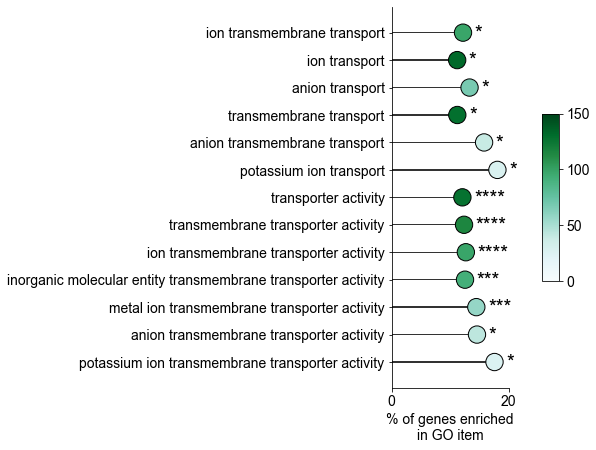

In [24]:
plt.figure(figsize=(3,7))
echo_utils.plot_go_items(df_goea_sig_neg)
plt.clim([0, 150])
plt.xticks([0, 0.2], ['0', '20']);

The GO items can be visualized as above, where the x-position of the marker represents the % of genes that are enriched in that GO item, while its color indicates how many genes from that GO item are enriched. Asterisks indicate statistical significance from Fisher's exact test (FDR-corrected).

We can also print out the list of the enriched genes that belong in the GO item, i.e., these are the genes that have significant PLS weights and are also in the chosen GO item (black bars in the histogram from a few cells above).

In [25]:
echo_utils.print_go_genes(goea_results_neg[-1], id2symbol_dict)

------ potassium ion transmembrane transporter activity --------
26 enriched genes in GO item:
ABCC8, ATP1A3, ATP1B3, ATP4A, HCN1, KCNA1, KCNAB3, KCNB1, KCNC1, KCNC4, KCNH1, KCNIP3, KCNJ2, KCNJ3, KCNK12, KCNMB3, KCNQ5, KCNS2, KCNT1, PKD2, SLC12A6, SLC12A7, SLC24A2, SLC24A5, SNAP25, TMEM38A, -----


### In summary, by applying GOEA, an approach that is statistical and unbiased by experimenter selection (only parameter of choice being threshold for statistical significance in PLS weights), we find that the expression of genes highly correlated with neuronal timescale gradient across cortex are associated with functional gene groupings related mainly to transmembrane ionic transport. Genes that are positively correlated to timescale gradient seem to control cellular regulatory processes, while those negatively correlated to timescale are related to transmembrane transport.

---
---
# Regressing out anatomical gradient from timescale and transcriptomic gradients
As shown previously (Burt et al., 2018), there is significant correlation between anatomical hierarchy (T1w/T2w gradient) and transcriptomic hierarchy. As expected, both gradients are further correlated with neuronal timescale hierarchy across the human cortex. While it would be shocking if variations of brain structural variables were not related to variations in neural dynamics, either causally or through some intermediate variable, a less charitable view is that the findings above are completely unsurprising, since macroscopic gradients across the cortex are surely correlated with each other, perhaps through a common latent gradient (though that does not make it true a priori). 

In fact, these gradients are unlikely to be shaped by the same latent variable since they do not describe the same level of phenomenon: gene expression differences across the cortex first result in cell type and connectivity differences, contributing (at least partially) to the hierarchical organization of coarse anatomy as measured via T1w/T2w. Consequently, both gene expression and anatomical gradients then shape variations in neuronal dynamics across cortex through local or long-range connectivity and expression of synaptic receptors with different subunits of differing activation timescales. 

Therefore, we ask in the final section here whether the transcriptomic gradient is still significantly related to neuronal timescale after removing the co-varying factor in anatomical hierarchy. To do so, we fit a linear regression model between T1w/T2w (x) and timescale gradients (y), and compute the residual between the fitted and empirical timescale values (y_hat - y). We do the same between T1w/T2w and every gene, resulting in a matrix of gene residuals. Finally, we compare timescale and gene expression residuals, as we did with their gradients in the analyses above.

If all 3 hierarchies are shaped by a single common latent gradient, partialling out T1w/T2w variation from both gene expression and timescale gradients should remove a significant amount of correlation between the latter two. We would then expect a random assortment of genes to be associated with timescale, if any at all, and performing gene ontology enrichment analysis on those gene residuals that appear enriched by chance should return no sensible functional gene groupings (GO items). 

In contrast, if there are genes that contribute to timescale variation much more so than they do for anatomical hierarchy, even if they predominantly follow the same hierarchical organization along the rostrocaudal axis of the cortex, then we would expect those functional gene clusters to survive the residual GO enrichment analysis, albeit with reduced gene-timescale correlations. 

In [26]:
### ----- REGRESS OUT T1/T2 from timescale and gene
# regress out T1T2 from timescale features
x = df_struct['T1T2'].values
df_tau_rmvt1t2, _ = echo_utils.get_residuals(x, df_tau)

# remove T1/T2 contribution from all genes by regressing out and get gene residuals
df_genes_rmvt1t2, genes_t1t2_coeffs = echo_utils.get_residuals(x, df_genes)

# compute timescale-gene residual correlations
y = df_tau_rmvt1t2['logtau']
df_tau_gene_corrall_rmvt1t2 = pd.DataFrame([spearmanr(g.values, y.values) for g_i, g in df_genes_rmvt1t2.iteritems()], columns=['rho','pv'], index=df_genes.columns)

colormap sequential: [9.87e-01, 1.34e+00, 1.69e+00] (opaque)
colormap sequential: [-3.31e-01, 8.87e-02, 5.09e-01] (opaque)


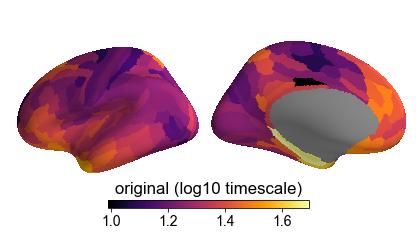

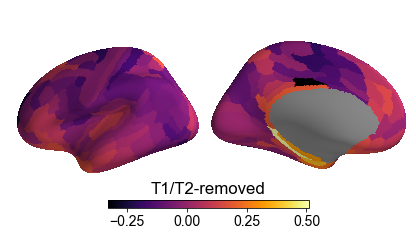

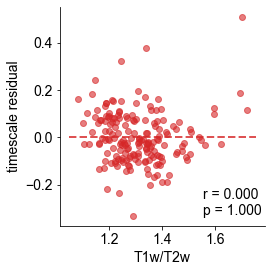

In [27]:
plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau['logtau'], bp=0, title='original (log10 timescale)', cmap='inferno')

plt.figure(figsize=(6,6))
echo_utils.plot_MMP(df_tau_rmvt1t2['logtau'], save_file=fig_path%'map_tau_log_t1t2rmv', bp=0, title='T1/T2-removed', cmap='inferno')

plt.figure(figsize=(4,4))
plt.plot(df_struct['T1T2'], df_tau_rmvt1t2['logtau'], 'o', color=C_ORD[3], alpha=0.6)
m,b,_,_,_ = linregress(df_struct['T1T2'], df_tau_rmvt1t2['logtau'].values)
XL= np.array(plt.xlim())
plt.plot(XL,XL*m+b, '--', lw=2, color=C_ORD[3], alpha=0.8) 

r,pv = pearsonr(df_struct['T1T2'], df_tau_rmvt1t2['logtau'])
plt.annotate(echo_utils.sig_str(r, pv, form='text', corr_letter='r'), xy=(0.7,0.05), xycoords='axes fraction');
plt.xlabel('T1w/T2w');plt.ylabel('timescale residual');
despine(); plt.tight_layout()
plt.savefig(fig_path%'tau_T1T2_rmvt1t2', bbox_inches='tight')

Plotted above are the original timescale gradient (top) and the residual map (middle). Overall, variation across cortex is reduced in the residual map (less extreme colors), but qualitatively, regions of extreme timescales are conserved (e.g., medial frontal, medial temporal, etc.)

Scatterplot shows correlation between T1w/T2w and timescale residual, confirming that correlation between the two is indeed removed.

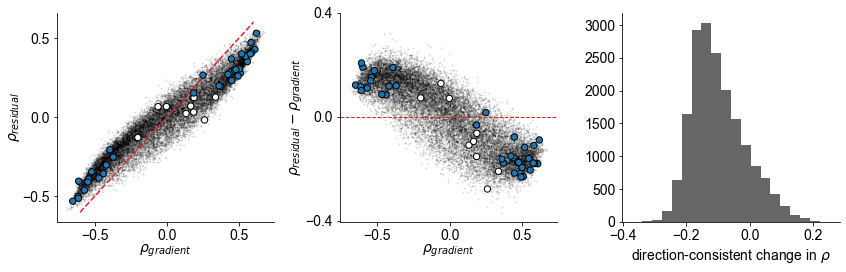

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(df_tau_gene_corrall['rho'], df_tau_gene_corrall_rmvt1t2['rho'], 'k.', ms=2, alpha=0.1)
plt.plot([-0.6, 0.6],[-0.6, 0.6], '--', color=C_ORD[3])
for i_g, gs in enumerate(gene_families):
    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_tau_gene_corrall_rmvt1t2.loc[gs]['pv']]
    plt.scatter(df_tau_gene_corrall.loc[gs]['rho'], df_tau_gene_corrall_rmvt1t2.loc[gs]['rho'], alpha=1, s=40, ec='k', fc=set_color, zorder=10)

plt.xticks([-0.5,0,0.5]);plt.yticks([-0.5,0,0.5])
plt.xlabel(r'$\rho_{gradient }$', labelpad=0);plt.ylabel(r'$\rho_{residual}$',labelpad=0)

plt.subplot(1,3,2)
plt.plot(df_tau_gene_corrall['rho'], df_tau_gene_corrall_rmvt1t2['rho']-df_tau_gene_corrall['rho'], 'k.', ms=2, alpha=0.1)

for i_g, gs in enumerate(gene_families):
    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_tau_gene_corrall_rmvt1t2.loc[gs]['pv']]
    plt.scatter(df_tau_gene_corrall.loc[gs]['rho'], df_tau_gene_corrall_rmvt1t2.loc[gs]['rho']-df_tau_gene_corrall.loc[gs]['rho'], alpha=1, s=40, ec='k', fc=set_color, zorder=10)
    
plt.xticks([-0.5,0,0.5]);plt.yticks([-0.4,0,0.4])
plt.axhline(0, ls='--', c=C_ORD[3], lw=1)
plt.xlabel(r'$\rho_{gradient}$',labelpad=0);plt.ylabel(r'$\rho_{residual} - \rho_{gradient}$', labelpad=0)

plt.subplot(1,3,3)
plt.hist(np.sign(df_tau_gene_corrall['rho'])*(df_tau_gene_corrall_rmvt1t2['rho']-df_tau_gene_corrall['rho']), 20, color='k', alpha=0.6)
plt.xlabel(r'direction-consistent change in $\rho$')
despine(); plt.tight_layout()

plt.savefig(fig_path%'tau_gene_rmvt1t2_corr_change', bbox_inches='tight')

### Removing T1w/T2w reduces magnitude of correlation between timescale and gene expression
In the first and second plots above, each dot is one gene, and plotted on the left is the correlation between timescale and gene expression gradients on the x-axis vs. the correlation between the residuals on the y-axis. Larger dots are the example genes from the gene families above, and blue-filled ones are significant under p<0.05. The middle plot is the the same, but change in correlation is on the y-axis instead. The last plot shows the distribution of direction-consistent change in correlation, i.e., -0.2 means a change that is opposite to the original direction of correlation by 0.2.

From these plots, we see that most genes experience a change opposite to their direction of correlation after removing the contribution of anatomical gradient. This is especially true for genes with the most extreme correlations to timescale, i.e, most genes that were positively correlated are now less so, with the most positively correlated ones seeing the biggest decrease in correlation, and the converse is true for the negatively correlated genes - as expected. 

In [29]:
# fit PLS to timescale & gene residual
pls = PLSRegression(n_components=1)
X = df_genes_rmvt1t2.values
Y = df_tau_rmvt1t2['logtau'].values
pls.fit(X, Y)
pls_coefs_emp_rmvt1t2 = pls.coef_.squeeze()

# have to make new surrogate maps for the T1T2-removed tau maps and
msr_nulls_rmvt1t2 = ts_msr.randomize(df_tau_rmvt1t2['logtau'].values)

# fit PLS to surrogate maps to get null distribution
pls_coefs_nulls_rmvt1t2 = np.zeros((msr_nulls_rmvt1t2.shape[0], len(pls_coefs_emp_rmvt1t2)))
for i_y, Y in enumerate(msr_nulls_rmvt1t2):
    pls.fit(X, Y)
    pls_coefs_nulls_rmvt1t2[i_y,:] = pls.coef_.squeeze()
    
# find permuted p-values
pv_pls_coefs_rmvt1t2 = 1-(abs(pls_coefs_emp_rmvt1t2)>abs(pls_coefs_nulls_rmvt1t2)).sum(0)/msr_nulls_rmvt1t2.shape[0]

# make df of genes and their PLS weights & pvalues
df_pls_rmvt1t2 = pd.DataFrame(
    np.vstack((pls_coefs_emp_rmvt1t2, zscore(pls_coefs_emp_rmvt1t2), pv_pls_coefs_rmvt1t2)).T, 
    columns=['w', 'w_zscore', 'pv'], 
    index=df_genes.columns)

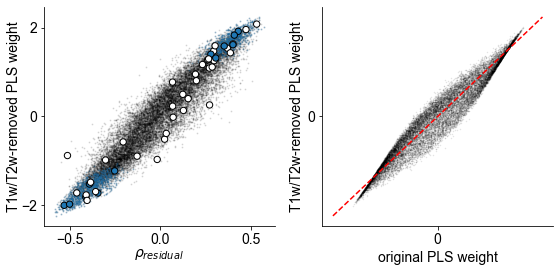

In [30]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(df_tau_gene_corrall_rmvt1t2['rho'], df_pls_rmvt1t2['w_zscore'], 'k.', alpha=0.1, ms=2)
plt.plot(df_tau_gene_corrall_rmvt1t2[df_pls_rmvt1t2['pv']<0.05]['rho'], df_pls_rmvt1t2[df_pls_rmvt1t2['pv']<0.05]['w_zscore'], '.', color=C_ORD[0], alpha=0.2, ms=2)

for i_g, gs in enumerate(gene_families):
    # color based on permutation significance
    set_color = [C_ORD[0] if p<0.05 else 'w' for p in df_pls_rmvt1t2.loc[gs]['pv']]
    plt.scatter(df_tau_gene_corrall_rmvt1t2.loc[gs]['rho'], df_pls_rmvt1t2['w_zscore'].loc[gs], alpha=1, s=40, ec='k', fc=set_color, zorder=10)
    
plt.xticks([-0.5,0,0.5]);plt.yticks([-2,0,2])
plt.xlabel(r'$\rho_{residual}$',labelpad=0);plt.ylabel('T1w/T2w-removed PLS weight', labelpad=0)

plt.subplot(1,2,2)
plt.plot(df_pls['w_zscore'],df_pls_rmvt1t2['w_zscore'], 'k.', ms=1, alpha=0.1)
plt.plot(np.array([-2.5,2.5]), np.array([-2.5,2.5]), 'r--')
plt.xlabel('original PLS weight'); plt.ylabel('T1w/T2w-removed PLS weight');
plt.xticks([0]);plt.yticks([0]);
plt.tight_layout(); despine()

despine(); plt.tight_layout()
plt.savefig(fig_path%'tau_gene_rmvt1t2_corrPLS', bbox_inches='tight')

### Residual PLS weight is correlated with original PLS weight, and residual correlation
No surprises here: the new PLS weights (fit to timescale and gene residual) are correlated to the Spearman correlation between timescale and gene residual, as well as original the PLS weights. 

Actually, I take that back, the second plot shows something pretty interesting actually: there are two dense tails in PLS weights (one negative and one positive, about first and last quartile), and within those tails, genes with large weights (in absolute magnitude) in the original model now have even larger weights in the residual model. This is unexpected, as the amplification of PLS weights is the opposite of the effect we saw for Spearman correlation above, i.e., dampening of correlation values.

In [31]:
# check that Pearson correlations are now zero between all genes and T1T2
df_genet1t2rmv_corrall = pd.DataFrame(
    [pearsonr(g.values, df_struct['T1T2'].values) for g_i, g in df_genes_rmvt1t2.iteritems()], 
    columns=['rho','pv'], index=df_genes.columns)

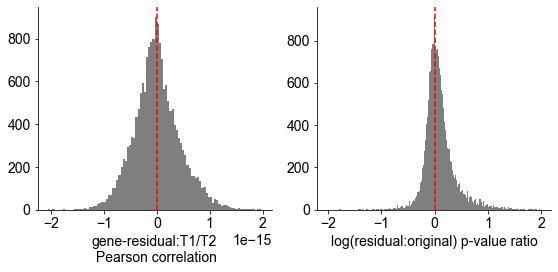

In [32]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.hist(df_genet1t2rmv_corrall['rho'].values, 100, color='k', alpha=0.5)
plt.xlabel('gene-residual:T1/T2\n Pearson correlation')
plt.axvline(0, color='r', ls='--')

plt.subplot(1,2,2)
plt.hist(np.log10(df_pls_rmvt1t2['pv'].values/df_pls['pv'].values), bins=np.arange(-2,2,0.02), color='k', alpha=0.5)
plt.xlabel('log(residual:original) p-value ratio')
plt.axvline(0, color='r', ls='--')
plt.tight_layout(); despine()


Again, just checking that gene residuals are uncorrelated with T1w/T2w, and they look to be.

### Running GOEA on genes with high residual correlations

In [33]:
_, df_goea_sig_rmvt1t2, goea_results_sig_rmvt1t2, _ = echo_utils.run_goea(df_pls_rmvt1t2, symbol2id_dict, goea_obj, posneg='all')


Run BP Gene Ontology Analysis: current study set of 1937 IDs ...
 84%  1,623 of  1,937 study items found in association
100%  1,937 of  1,937 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   8,102 GO terms are associated with  1,623 of  1,937 study items
  METHOD fdr_bh:
       0 GO terms found significant (< 0.05=alpha) (  0 enriched +   0 purified): statsmodels fdr_bh
       0 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1937 IDs ...
 89%  1,718 of  1,937 study items found in association
100%  1,937 of  1,937 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
   1,066 GO terms are associated with  1,718

In [34]:
# new GOEA result with residuals
df_goea_sig_rmvt1t2.iloc[[1,2,3,0,4,5]]

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
15227,GO:1990351,e,CC,2,transporter complex,59,312,0.030459,0.008270
15228,GO:1902495,e,CC,3,transmembrane transporter complex,58,304,0.029943,0.008270
15229,GO:0034703,e,CC,5,cation channel complex,43,207,0.022199,0.009664
15226,GO:0034702,e,CC,4,ion channel complex,55,282,0.028394,0.008270
15230,GO:0098982,e,CC,4,GABA-ergic synapse,19,71,0.009809,0.045944
15231,GO:1902711,e,CC,4,GABA-A receptor complex,7,13,0.003614,0.048418


In [35]:
# original GOEA result
df_goea_sig

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
15226,GO:1990351,e,CC,2,transporter complex,77,312,0.027208,0.026890
15227,GO:1902495,e,CC,3,transmembrane transporter complex,75,304,0.026502,0.026890
15228,GO:0034702,e,CC,4,ion channel complex,70,282,0.024735,0.030218
15229,GO:0034703,e,CC,5,cation channel complex,54,207,0.019081,0.032011
16047,GO:1990904,p,CC,2,ribonucleoprotein complex,65,644,0.022968,0.026890
16048,GO:0005634,p,CC,5,nucleus,654,4720,0.231095,0.032011


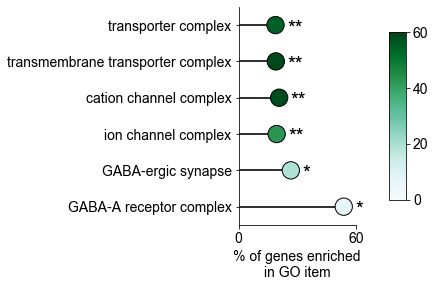

In [36]:
plt.figure(figsize=(3,4))
echo_utils.plot_go_items(df_goea_sig_rmvt1t2,6,[1,2,3,0,4,5])
plt.clim([0, 60])
plt.xticks([0, 0.6], ['0', '60']);
plt.savefig(fig_path%'GOEA_res_rmvt1t2', bbox_inches='tight')

### Genes highly associated with timescale, after removing T1w/T2w, are (more) related to channel transporter complexs
After removing T1w/T2w as an intermediate covariate, genes with residuals that are significantly associated with timescale residuals are still the ones that are related to ionic transporter complexes. In fact, because there is a decreased number of genes that survive the significance threshold in the new PLS model, the first 4 GO items have a higher "ratio in study". In other words, regressing out T1w/T2w preferentially removed genes that are __not__ related to transmembrane transport, hence resulting in a higher enrichment ratio. As a result, the p-value for those 4 GO items are also much lower in the residual analysis. Lastly, partialling out T1w/T2w revealed functional groups related to GABAergic signaling, specifically GABA-A synapses. This again suggests an important role for fast inhibitory synapses in tuning timescale of transmembrane current fluctuations.

In [37]:
_, df_goea_sig_rmvt1t2_pos, goea_results_sig_rmvt1t2_pos, _ = echo_utils.run_goea(df_pls_rmvt1t2, symbol2id_dict, goea_obj, posneg='pos')
df_goea_sig_rmvt1t2_pos


Run BP Gene Ontology Analysis: current study set of 820 IDs ...
 81%    663 of    820 study items found in association
100%    820 of    820 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   5,862 GO terms are associated with    663 of    820 study items
  METHOD fdr_bh:
      64 GO terms found significant (< 0.05=alpha) ( 56 enriched +   8 purified): statsmodels fdr_bh
     341 study items associated with significant GO IDs (enriched)
     194 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 820 IDs ...
 88%    723 of    820 study items found in association
100%    820 of    820 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
     757 GO terms are associated with    723 o

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
0,GO:0050866,e,BP,5,negative regulation of cell activation,28,169,0.034146,0.000038
1,GO:0002376,e,BP,1,immune system process,133,1794,0.162195,0.000056
2,GO:0006955,e,BP,2,immune response,68,759,0.082927,0.000436
3,GO:0002695,e,BP,6,negative regulation of leukocyte activation,23,149,0.028049,0.000940
4,GO:0045087,e,BP,6,innate immune response,39,368,0.047561,0.002040
...,...,...,...,...,...,...,...,...,...
15233,GO:0043235,e,CC,2,receptor complex,33,367,0.040244,0.040892
15234,GO:0031224,e,CC,2,intrinsic component of membrane,242,4342,0.295122,0.040892
15235,GO:0031514,e,CC,5,motile cilium,15,116,0.018293,0.043986
15236,GO:0000839,e,CC,8,Hrd1p ubiquitin ligase ERAD-L complex,4,8,0.004878,0.043986


In [38]:
[print(n['enrichment'], n['branch'], n['ID'], n['name'], n['pv']) for i_n, n in df_goea_sig_rmvt1t2_pos.iterrows()];

e BP GO:0050866 negative regulation of cell activation 3.7622466894034244e-05
e BP GO:0002376 immune system process 5.585357137353725e-05
e BP GO:0006955 immune response 0.00043551795586824275
e BP GO:0002695 negative regulation of leukocyte activation 0.0009395847045961612
e BP GO:0045087 innate immune response 0.002040263461957998
e BP GO:0050865 regulation of cell activation 0.002040263461957998
e BP GO:0045321 leukocyte activation 0.0044704748391742885
e BP GO:0051250 negative regulation of lymphocyte activation 0.005215583028413209
e BP GO:0070663 regulation of leukocyte proliferation 0.005215583028413209
e BP GO:0002252 immune effector process 0.0060047893208424324
e BP GO:0050670 regulation of lymphocyte proliferation 0.006600218735947239
e BP GO:0032944 regulation of mononuclear cell proliferation 0.006662461783137506
e BP GO:0032956 regulation of actin cytoskeleton organization 0.006909261187675446
e BP GO:0002682 regulation of immune system process 0.006909261187675446
e BP G

In [39]:
_, df_goea_sig_rmvt1t2_neg, goea_results_sig_rmvt1t2_neg, _ = echo_utils.run_goea(df_pls_rmvt1t2, symbol2id_dict, goea_obj, posneg='neg')
df_goea_sig_rmvt1t2_neg


Run BP Gene Ontology Analysis: current study set of 1117 IDs ...
 86%    960 of  1,117 study items found in association
100%  1,117 of  1,117 study items found in population(18114)
Calculating 15,226 uncorrected p-values using fisher_scipy_stats
  15,226 GO terms are associated with 14,978 of 18,114 population items
   6,299 GO terms are associated with    960 of  1,117 study items
  METHOD fdr_bh:
       2 GO terms found significant (< 0.05=alpha) (  2 enriched +   0 purified): statsmodels fdr_bh
      28 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 1117 IDs ...
 89%    995 of  1,117 study items found in association
100%  1,117 of  1,117 study items found in population(18114)
Calculating 1,919 uncorrected p-values using fisher_scipy_stats
   1,919 GO terms are associated with 15,830 of 18,114 population items
     857 GO terms are associated with    995

,ID,enrichment,branch,depth,name,n_enriched,n_in_cat,ratio_in_study,pv
0,GO:0006813,e,BP,7,potassium ion transport,28,155,0.025067,0.003853
1,GO:0071805,e,BP,8,potassium ion transmembrane transport,26,146,0.023277,0.006807
17145,GO:0022857,e,MF,2,transmembrane transporter activity,97,938,0.086840,0.001928
17146,GO:0015079,e,MF,7,potassium ion transmembrane transporter activity,26,148,0.023277,0.002663
17147,GO:0005215,e,MF,1,transporter activity,104,1059,0.093107,0.002826
17148,GO:0015075,e,MF,3,ion transmembrane transporter activity,81,781,0.072516,0.004104
17149,GO:0046873,e,MF,6,metal ion transmembrane transporter activity,49,401,0.043868,0.004104
17150,GO:0015318,e,MF,3,inorganic molecular entity transmembrane trans...,74,734,0.066249,0.016954
17151,GO:0005244,e,MF,7,voltage-gated ion channel activity,27,183,0.024172,0.016954
17152,GO:0022832,e,MF,6,voltage-gated channel activity,27,183,0.024172,0.016954


Once again, positively-associated genes return a list of GO items related to weird cell machinery regulatory and immune response (??) processes, with almost no selection of transmembrane transporter protein-related genes, while negatively-associated genes are related to ion transport, and specifically, potassium transport. These results indicate that regressing out anatomical hierarchy still preserves the most prominent gene-timescale relationships.

### Overall, timescale hierarchy is robustly associated with expression of genes relevant for transmembrane ionic transport, such as voltage gated sodium and potassium channels, as well as for GABAergic receptor subunit.

---

In [40]:
# # compute correlation of timescale with individual genes
# df_tau_corr_all = pd.DataFrame(index=df_struct.columns[1:], columns=['rho', 'pv'])
# for i_f, s_f in enumerate(df_struct.columns[1:]):
#     # no resampling
#     rho, pv = spearmanr(df_struct[s_f], tau_parcel.values, nan_policy='omit')    
#     # resample, takes really long
#     #rho, _, pv, _ = echo_utils.perm_spearman(df_struct[s_f], tau_parcel.values)
#     df_tau_corr_all.loc[s_f] = rho, pv

In [41]:
# # threshold "high-correlation genes" by their correlation value, if they're greater than the timescale-PC1 correlation
# rho_pc1 = np.abs(echo_utils.perm_spearman(gene_grad[:,0],tau_parcel.values, 1000, 'shuffle')[0])
# print(rho_pc1)

# # print out all the genes that are more correlated to timescale than overall expression gradient (PC1) for GeneOntology analysis
# df_overexpr = df_tau_corr_all[np.abs(df_tau_corr_all['rho'])>rho_pc1].sort_values('rho')
# print(len(df_overexpr), len(df_tau_corr_all))
# echo_utils.print_gene_list(df_overexpr, 'go_over_correlated.txt')
# echo_utils.print_gene_list(df_overexpr[df_overexpr['rho']>0], 'go_over_correlated_pos.txt')
# echo_utils.print_gene_list(df_overexpr[df_overexpr['rho']<0], 'go_over_correlated_neg.txt')


# # also print the same number of genes with the highest pc1 loadings
# df_high_pc1 = np.abs(df_pc_weights).sort_values('pc1')[-len(df_overexpr):]
# echo_utils.print_gene_list(df_high_pc1, 'go_high_pc1.txt')

# # print genes that are in the high-correlation set but not in high pc1 loading set
# diff_corr_pc1_genes = list(np.setdiff1d(df_overexpr.index.values, df_high_pc1.index.values))
# echo_utils.print_gene_list(diff_corr_pc1_genes, 'go_diff_corr_pc1.txt')

# plt.figure(figsize=(12,4))
# # distribution of rho values over all genes
# plt.subplot(1,3,1)
# plt.hist(df_tau_corr_all['rho'], 50, color='k', alpha=0.3);
# plt.hist(df_tau_corr_all[df_tau_corr_all['pv']<0.05/len(df_tau_corr_all)]['rho'], 50, color='k', alpha=0.2); # shade those surviving Bonferroni correction at p=0.05
# YL = plt.ylim()
# # mark rho value for timescale-genePC1
# plt.plot([rho_pc1]*2, YL, 'b--'); plt.plot([-rho_pc1]*2, YL, 'b--');
# plt.xlabel('Spearman Rho'); plt.ylabel('# of Genes')
# subinds = df_tau_corr_all.index.isin(df_high_pc1.index)
# plt.hist(df_tau_corr_all[subinds]['rho'], 50, fc='r', alpha=0.5)
# subinds = df_tau_corr_all.index.isin(df_overexpr.index)
# plt.hist(df_tau_corr_all[subinds]['rho'], 50, fc='b', alpha=0.5)
# despine(); 

# # distribution of PC1 weighting
# plt.subplot(1,3,2)
# plt.hist(df_pc_weights['pc1'], 50, fc='k', alpha=0.3)
# plt.hist(df_pc_weights[df_tau_corr_all['pv']<0.05/len(df_tau_corr_all)]['pc1'], 50, color='k', alpha=0.2); # shade those surviving Bonferroni correction at p=0.05
# subinds = df_tau_corr_all.index.isin(df_high_pc1.index)
# plt.hist(df_pc_weights[subinds]['pc1'], 50, fc='r', alpha=0.5)
# subinds = df_tau_corr_all.index.isin(df_overexpr.index)
# plt.hist(df_pc_weights[subinds]['pc1'], 50, fc='b', alpha=0.5)
# plt.xlabel('PC1 Weight');
# despine()

# # scatterplot of correlation magnitude against PC1 weight for all genes
# plt.subplot(1,3,3)
# plt.plot(df_tau_corr_all['rho'], df_pc_weights['pc1'], 'k.', alpha=0.1, ms=2)
# subinds = df_tau_corr_all.index.isin(df_overexpr.index)
# plt.plot(df_tau_corr_all[subinds]['rho'], df_pc_weights[subinds]['pc1'], 'r.', ms=2, alpha=0.5) 
# subinds = df_tau_corr_all.index.isin(list(np.setdiff1d(df_overexpr.index.values, df_high_pc1.index.values)))
# plt.plot(df_tau_corr_all[subinds]['rho'], df_pc_weights[subinds]['pc1'], 'b.', ms=2, alpha=0.5) 
# plt.xlabel('Spearman Rho');plt.ylabel('PC1 Weight');despine()
# plt.legend(['All', '+Corr/+PC', '+Corr Only'], markerscale=5, fancybox=False, frameon=False, handletextpad=0)

# plt.tight_layout()

### Genes Highly Associated with Neuronal Timescale are Specific to Ion Transporters and Synaptic Reptors
In the above analysis, we find all genes that are more correlated (in absolute value) with timescale than PC1 is (~0.571), marked in blue (N=857 in total). That threshold is denoted by the blue dotted lines in the distribution of rho values in the first plot. These are genes that have a higher association with timescale than to be expected from the gene expression gradient alone. Those with significant correlations surviving Bonferroni correction are shaded darker. Many of these genes also happen to be highly loaded on PC1 (blue points in second histogram), i.e., they follow the generic rostrocaudal gradient of brain organization, though the sub-distributions are more normally distributed, implying a spread within the covariation. 

What we want to find is the list of genes that __are higly associated with timescale but not the generic structural gradient__, and flag them as timescale-specific genes. To do that, we find the same number of genes (top N=857) that are the most loaded along PC1 (colored red). From the high-correlation list of genes, we remove any genes that are also in the high-PC1-loading list, resulting in `diff_corr_pc1_genes`. The third plot shows all genes, and their timescale-correlation and PC1 loading. The red genes are excluded, resulting in all the blue genes that are more associated with timescale gradient than the generic transcriptomic gradient.

We submit that list for [GeneOntology analysis][GO], resulting in a list of molecular functions and cellular components that are more associated with this list of genes than by chance (compare to the whole list as reference). To do this, go to GeneOntology (follow the link) and submit `go_diff_corr_pc1.txt` as the analysis list, and `go_ref_list` as the reference list. 

Printed below are the list of molecular functions that are associated with the highly correlated genes than by chance, which include sodium and potassium transmembrane transporters, as well as voltage-gated potassium channel. Cellular component analysis results in similar answers. See images in `../data/img/GO_results` for list. Crucially, submitting the list of genes that have high PC1 loading does not result in overexpression of any specific functions related to transmembrane ionic transport. We can repeat this analysis with only genes that are more __positively__ correlated with timescale, also resulting in a list of cellular components highly associated with synaptic receptor and ion channel complexes (`GO_results/pos_GO_cellularcomp.png`).

__Overall, these data suggests that neuronal timescales are associated (potentially causally supported) by expression of genes associated with synaptic receptor and transmembrane ion transport, above and beyond the generic rostrocaudal gene expression gradient would imply.__

[GO]:http://pantherdb.org/tools/compareToRefList.jsp

https://www.genecards.org/Search/Keyword?queryString=%22membrane%20time%20constant%22

(../data/img/GO_results/diff_GO_molecularfunc.png)

---
# Supplemental Goodies

---
# Pool into 21 Glasser Macro Regions
This section repeats the key analyses from above, but with the 22 macro regions found in Glasser et al., 2018 Supplemental, so we can visualize (label) to see if any regions stand out. V1 parcel had its own group so I lumped it with "early visual" (hence 21 regions). All parcels within a macro region are then averaged, both for timescale and structural measures.

In [102]:
mmp_aggr = pd.read_csv('../data/mmp_macro.csv', index_col=0, names=['parcel','macro_region', 'macro_labels'])
# aggregating by macro region
df_tau_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_labels']))
df_struct_macro = pd.DataFrame(columns=np.unique(mmp_aggr['macro_labels']))
for i_r, r in mmp_aggr.groupby('macro_labels'):
    df_tau_macro[i_r] = echo_utils.compute_weighted_average(df_tau_weighted[r['parcel']], df_W_max[r['parcel']], axis=1, method='thresh_weighted')
    df_struct_macro[i_r] = df_struct.loc[['_'.join(p.split('-')) for p in r['parcel'].values]].mean(axis=0)
    
df_struct_macro = df_struct_macro.T
df_tau_macro_mean = df_tau_macro.mean(0)

### Spatial Correlation with T1w/T2w and Gene Expression

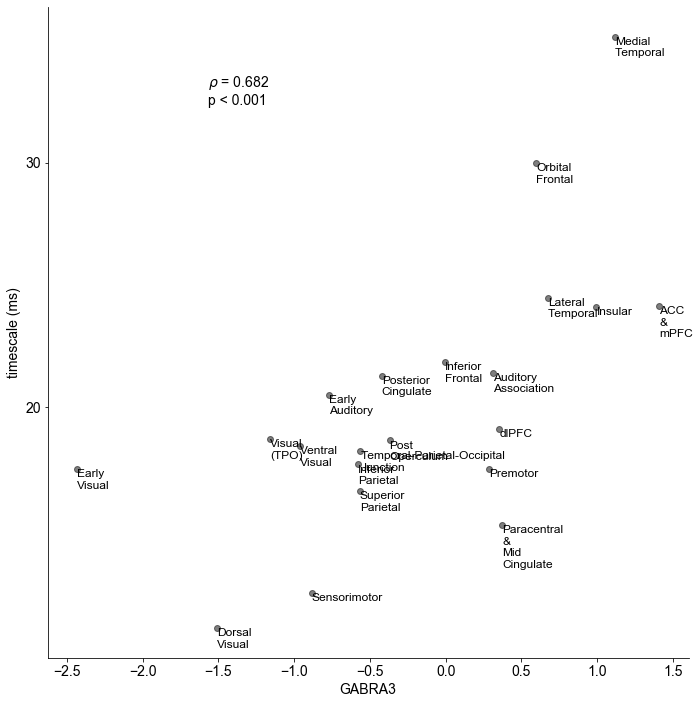

In [103]:
struct_feat = 'GABRA3'
plt.figure(figsize=(10,10))
x = df_struct_macro[struct_feat]
y = df_tau_macro_mean

plt.plot(x,y, 'ok', alpha=0.5)
for mr in df_struct_macro.index:
    plt.annotate('\n'.join(mr.split(' ')), (df_struct_macro.loc[mr][struct_feat], df_tau_macro_mean[mr]), 
                 horizontalalignment='left', verticalalignment='top', fontsize=12)
    
plt.yscale('log'); 
plt.xlabel(struct_feat); plt.ylabel('timescale (ms)');despine()
plt.yticks(np.arange(0.02,0.04, 0.01), (np.arange(0.02,0.04, 0.01)*1000).astype(int)); 
plt.tick_params('y', which='minor', left=False, labelleft=False)
rho, pv = spearmanr(df_struct_macro[struct_feat],df_tau_macro.mean(0), nan_policy='omit')
plt.annotate(echo_utils.sig_str(rho, pv, form='text'), xy=(0.25, 0.85), xycoords='axes fraction');
plt.tight_layout()

Macro region correlations between timescale and structural variables are even stronger, exemplified by the above for GRIN2B (also try PV+). As expected, early sensory regions (visual, primary sensory/motor) have very short timescales, while association regions (medial temporal, frontal) have longer timescales. 

In [107]:
# save out macro features
pd.concat((df_tau_macro_mean.to_frame(name = 'tau'), df_struct_macro), axis=1).to_csv('../data/df_human_features_macro.csv')
df_tau_macro_mean

ACC & mPFC                              0.023665
Auditory Association                    0.021186
Dorsal Visual                           0.013874
Early Auditory                          0.020429
Early Visual                            0.018064
Inferior Frontal                        0.021552
Inferior Parietal                       0.018198
Insular                                 0.023636
Lateral Temporal                        0.023987
Medial Temporal                         0.036967
Orbital Frontal                         0.029974
Paracentral & Mid Cingulate             0.016467
Post Operculum                          0.018939
Posterior Cingulate                     0.021082
Premotor                                0.018056
Sensorimotor                            0.014705
Superior Parietal                       0.017408
Temporal-Parietal-Occipital Junction    0.018609
Ventral Visual                          0.018770
Visual (TPO)                            0.018975
dlPFC               